<a href="https://colab.research.google.com/github/sarvasvaKhare/Navier_Stokes_inverse/blob/main/Navier_Stokes_inverse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install deepxde
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re
!wget https://github.com/lululxvi/deepxde/blob/master/examples/dataset/cylinder_nektar_wake.mat?raw=true
!mv cylinder_nektar_wake.mat?raw=true cylinder_nektar_wake.mat
# true values
C1true = 1.0
C2true = 0.01

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-02-12 10:01:18--  https://github.com/lululxvi/deepxde/blob/master/examples/dataset/cylinder_nektar_wake.mat?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/lululxvi/deepxde/raw/master/examples/dataset/cylinder_nektar_wake.mat [following]
--2023-02-12 10:01:18--  https://github.com/lululxvi/deepxde/raw/master/examples/dataset/cylinder_nektar_wake.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lululxvi/deepxde/master/examples/dataset/cylinder_nektar_wake.mat [following]
--2023-02-12 10:01:18--  https://raw.githubusercontent.com/lululxvi/deepxde/master/examples/dataset/cylinder_nektar_wake.mat
Resolving raw.githubusercontent.co

In [12]:
# Parameters to be identified
C1 = dde.Variable(0.0)
C2 = dde.Variable(0.0)

In [3]:
def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    p = y[:, 2:3]
    du_x = dde.grad.jacobian(y, x, i=0, j=0)
    du_y = dde.grad.jacobian(y, x, i=0, j=1)
    du_t = dde.grad.jacobian(y, x, i=0, j=2)
    dv_x = dde.grad.jacobian(y, x, i=1, j=0)
    dv_y = dde.grad.jacobian(y, x, i=1, j=1)
    dv_t = dde.grad.jacobian(y, x, i=1, j=2)
    dp_x = dde.grad.jacobian(y, x, i=2, j=0)
    dp_y = dde.grad.jacobian(y, x, i=2, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    continuity = du_x + dv_y
    x_momentum = du_t + C1 * (u * du_x + v * du_y) + dp_x - C2 * (du_xx + du_yy)
    y_momentum = dv_t + C1 * (u * dv_x + v * dv_y) + dp_y - C2 * (dv_xx + dv_yy)
    return [continuity, x_momentum, y_momentum]

In [4]:
# Define Spatio-temporal domain
# Rectangular
Lx_min, Lx_max = 1.0, 8.0
Ly_min, Ly_max = -2.0, 2.0
# Spatial domain: X × Y = [1, 8] × [−2, 2]
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])
# Time domain: T = [0, 7]
time_domain = dde.geometry.TimeDomain(0, 7)
# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

In [5]:
def load_training_data(num):
    data = loadmat("cylinder_nektar_wake.mat")
    U_star = data["U_star"]  # N x 2 x T
    P_star = data["p_star"]  # N x T
    t_star = data["t"]  # T x 1
    X_star = data["X_star"]  # N x 2
    N = X_star.shape[0]
    T = t_star.shape[0]
    # Rearrange Data
    XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
    YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
    TT = np.tile(t_star, (1, N)).T  # N x T
    UU = U_star[:, 0, :]  # N x T
    VV = U_star[:, 1, :]  # N x T
    PP = P_star  # N x T
    x = XX.flatten()[:, None]  # NT x 1
    y = YY.flatten()[:, None]  # NT x 1
    t = TT.flatten()[:, None]  # NT x 1
    u = UU.flatten()[:, None]  # NT x 1
    v = VV.flatten()[:, None]  # NT x 1
    p = PP.flatten()[:, None]  # NT x 1
    # training domain: X × Y = [1, 8] × [−2, 2] and T = [0, 7]
    data1 = np.concatenate([x, y, t, u, v, p], 1)
    data2 = data1[:, :][data1[:, 2] <= 7]
    data3 = data2[:, :][data2[:, 0] >= 1]
    data4 = data3[:, :][data3[:, 0] <= 8]
    data5 = data4[:, :][data4[:, 1] >= -2]
    data_domain = data5[:, :][data5[:, 1] <= 2]
    # choose number of training points: num =7000
    idx = np.random.choice(data_domain.shape[0], num, replace=False)
    x_train = data_domain[idx, 0:1]
    y_train = data_domain[idx, 1:2]
    t_train = data_domain[idx, 2:3]
    u_train = data_domain[idx, 3:4]
    v_train = data_domain[idx, 4:5]
    p_train = data_domain[idx, 5:6]
    return [x_train, y_train, t_train, u_train, v_train, p_train]

In [8]:
[ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=7000)
ob_xyt = np.hstack((ob_x, ob_y, ob_t))
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)

In [9]:
data = dde.data.TimePDE(
    geomtime,
    Navier_Stokes_Equation,
    [observe_u, observe_v],
    num_domain=700,
    num_boundary=200,
    num_initial=100,
    anchors=ob_xyt,
)

In [10]:
layer_size = [3] + [50] * 6 + [3]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)

In [13]:
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue([C1, C2], period=100, filename=fnamevar)

In [14]:
model.compile("adam", lr=1e-3, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    iterations=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True
)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.8/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.272087 s

'compile' took 3.142479 s

Initializing variables...
Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.16e-03, 4.42e-03, 1.06e-02, 6.32e-01, 1.12e-01]    [3.16e-03, 4.42e-03, 1.06e-02, 6.32e-01, 1.12e-01]    []  
1000      [5.08e-04, 1.11e-03, 1.40e-03, 3.38e-03, 8.33e-03]    [5.08e-04, 1.11e-03, 1.40e-03, 3.38e-03, 8.33e-03]    []  
2000      [3.09e-04, 5.40e-04, 5.27e-04, 1.41e-03, 1.72e-03]    [3.09e-04, 5.40e-04, 5.27e-04, 1.41e-03, 1.72e-03]    []  
3000      [2.39e-04, 3.77e-04, 3.49e-04, 1.00e-03, 1.20e-03]    [2.39e-04, 3.77e-04, 3.49e-04, 1.00e-03, 1.20e-03]    []  
4000      [2.70e-04, 6.79e-04, 7.01e-04, 1.09e-03, 3.12e-03]    [2.70e-04, 6.79e-04, 7.01e-04, 1.09e-03, 3.12e-03]    []  
5000      [1.30e-04, 2.27e-04, 2.23e-04, 5.19e-04, 6.40e-04]    [1.30e-04, 2.27e-04, 2.23e-04, 5.19e-04, 6.40e-04]    []  
6000      [1.10e-04, 1.96e-04, 1.90

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


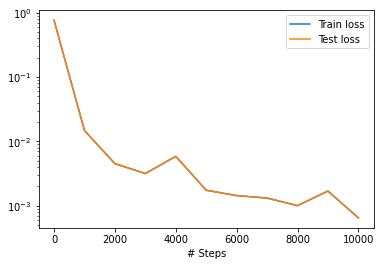

In [15]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

Compiling model...
'compile' took 2.017695 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
10000     [6.19e-05, 1.07e-04, 1.08e-04, 1.57e-04, 2.12e-04]    [6.19e-05, 1.07e-04, 1.08e-04, 1.57e-04, 2.12e-04]    []  
11000     [5.62e-05, 9.51e-05, 9.38e-05, 1.35e-04, 1.74e-04]    [5.62e-05, 9.51e-05, 9.38e-05, 1.35e-04, 1.74e-04]    []  
12000     [5.07e-05, 8.21e-05, 7.83e-05, 1.11e-04, 1.30e-04]    [5.07e-05, 8.21e-05, 7.83e-05, 1.11e-04, 1.30e-04]    []  
13000     [4.60e-05, 7.27e-05, 6.66e-05, 9.22e-05, 9.87e-05]    [4.60e-05, 7.27e-05, 6.66e-05, 9.22e-05, 9.87e-05]    []  
14000     [4.24e-05, 6.59e-05, 5.84e-05, 8.00e-05, 8.06e-05]    [4.24e-05, 6.59e-05, 5.84e-05, 8.00e-05, 8.06e-05]    []  
15000     [3.87e-05, 5.98e-05, 5.12e-05, 7.00e-05, 6.77e-05]    [3.87e-05, 5.98e-05, 5.12e-05, 7.00e-05, 6.77e-05]    []  
16000     [3.61e-05, 5.54e-05, 4.63e-05, 6.42e-05, 6.11e-05]    [3.

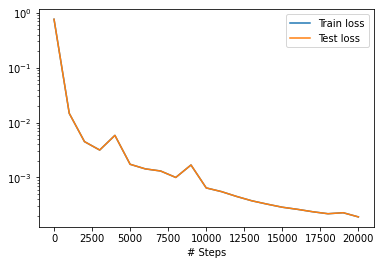

In [16]:
model.compile("adam", lr=1e-4, external_trainable_variables=[C1, C2])
loss_history, train_state = model.train(
    epochs=10000, callbacks=[variable], display_every=1000, disregard_previous_best=True
)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [17]:
f = model.predict(ob_xyt, operator=Navier_Stokes_Equation)
print("Mean residual:", np.mean(np.absolute(f)))

Mean residual: 0.0041209236


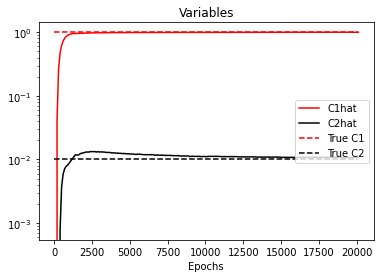

In [18]:
lines = open(fnamevar, "r").readlines()
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.semilogy(range(0, l * 100, 100), Chat[:, 0], "r-")
plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 0].shape) * C1true, "r--")
plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
plt.xlabel("Epochs")
plt.title("Variables")
plt.show()

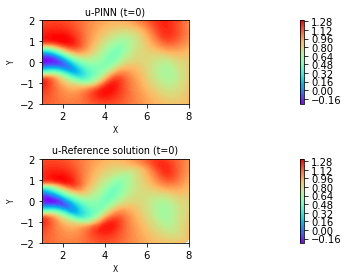

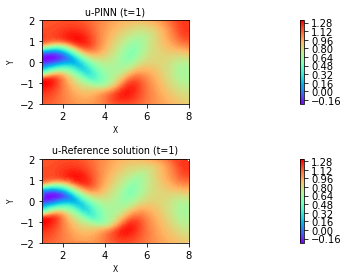

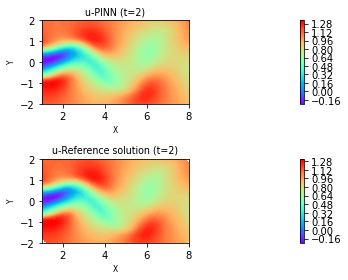

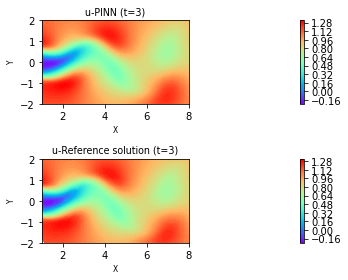

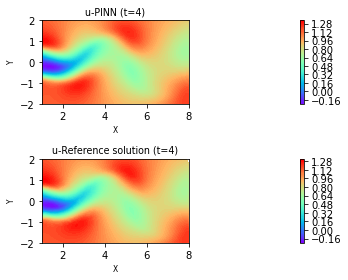

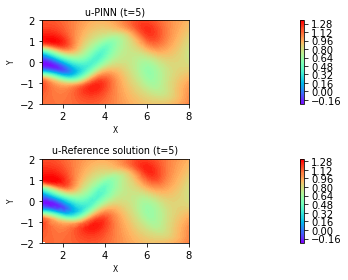

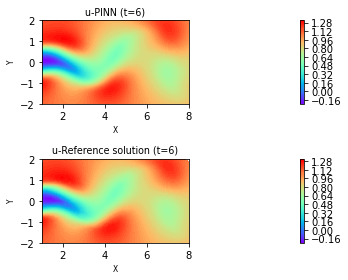

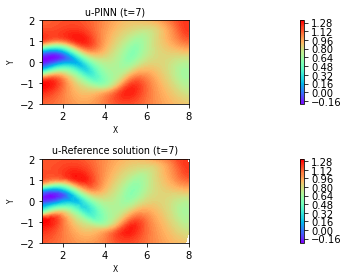

In [19]:
for t in range(0, 8):
    [ob_x, ob_y, ob_t, ob_u, ob_v, ob_p] = load_training_data(num=140000)
    xyt_pred = np.hstack((ob_x, ob_y, t * np.ones((len(ob_x), 1))))
    uvp_pred = model.predict(xyt_pred)
    x_pred, y_pred, t_pred = xyt_pred[:, 0], xyt_pred[:, 1], xyt_pred[:, 2]
    u_pred, v_pred, p_pred = uvp_pred[:, 0], uvp_pred[:, 1], uvp_pred[:, 2]
    x_true = ob_x[ob_t == t]
    y_true = ob_y[ob_t == t]
    u_true = ob_u[ob_t == t]
    fig, ax = plt.subplots(2, 1)
    cntr0 = ax[0].tricontourf(x_pred, y_pred, u_pred, levels=80, cmap="rainbow")
    cb0 = plt.colorbar(cntr0, ax=ax[0])
    cntr1 = ax[1].tricontourf(x_true, y_true, u_true, levels=80, cmap="rainbow")
    cb1 = plt.colorbar(cntr1, ax=ax[1])
    ax[0].set_title("u-PINN " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[0].axis("scaled")
    ax[0].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[0].set_ylabel("Y", fontsize=7.5, family="Arial")
    ax[1].set_title("u-Reference solution " + "(t=" + str(t) + ")", fontsize=9.5)
    ax[1].axis("scaled")
    ax[1].set_xlabel("X", fontsize=7.5, family="Arial")
    ax[1].set_ylabel("Y", fontsize=7.5, family="Arial")
    fig.tight_layout()
    plt.show()